### Uncomment and run the below code block if you do not already have the below libraries installed.

In [ ]:
# !pip install sklearn
# !pip install pandas

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import collections
import time
from sklearn import decomposition
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.linear_model import LogisticRegression 
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import sklearn
%matplotlib inline
print(sklearn.__version__)

1.0.2


In [3]:
# make sure your data matches the given name below, else edit it to desired name
# note: csv is assumed to be stored in /content/ . Change path if necessary
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/STO_data.csv')
# df1 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Colelcted_data_MUM.csv')
# check that the data is imported properly
df.head()


,SM,MM,shader,core,spunit,l1,latency,dl2,IPC
0,35,1,32,12,2048,64,82,128,291.7727
1,35,1,32,12,2048,64,82,64,291.7376
2,35,1,32,12,1024,32,82,128,291.7727
3,35,1,32,12,1536,64,35,64,291.6447
4,35,1,32,12,1024,64,20,128,291.4724


### Exploratory Data Analysis:

In [ ]:
df.mean()

SM          4.049875
MM          1.359102
shader     27.371571
core       27.800499
l1         47.800499
latency    45.576060
dl2        95.920200
IPC        10.179573
dtype: float64

In [ ]:
df.median()

SM         48.0000
MM          3.0000
shader     16.0000
core       24.0000
l1         32.0000
latency    35.0000
dl2        64.0000
IPC         9.3633
dtype: float64

In [ ]:
df.tail()

,SM,MM,shader,core,l1,latency,dl2,IPC
6642,92,8,16,24,32,20,64,10.2553
6643,92,8,16,24,32,20,128,10.2553
6644,92,8,16,24,32,35,64,9.4540
6645,92,8,16,24,32,35,128,9.4540
6646,92,8,16,24,32,82,64,7.5939


In [ ]:
df.describe()

,SM,MM,shader,core,l1,latency,dl2,IPC
count,6647.000000,6647.000000,6647.000000,6647.000000,6647.000000,6647.000000,6647.000000,6647.000000
mean,47.558147,3.324507,29.140364,27.865202,47.949451,45.633218,95.985557,9.433937
std,31.748303,1.978330,21.322100,14.941390,16.001124,26.405817,32.002404,1.525161
min,2.000000,1.000000,8.000000,12.000000,32.000000,20.000000,64.000000,4.074300
25%,15.000000,2.000000,8.000000,12.000000,32.000000,20.000000,64.000000,8.238500
50%,48.000000,3.000000,16.000000,24.000000,32.000000,35.000000,64.000000,9.363300
75%,76.000000,5.000000,32.000000,48.000000,64.000000,82.000000,128.000000,10.532100
max,99.000000,8.000000,64.000000,48.000000,64.000000,82.000000,128.000000,13.651000


In [4]:
df.shape

(6631, 9)

###Functions

In [5]:
#functions
def x_y_split(dataset, data_start, data_end, target_index):
    x_data = dataset[:, data_start:data_end+1]
    y_data = dataset[:, target_index]
    return x_data, y_data

def exclude_from_set(dataset, value, column_index, data_start, data_end, target_index):
    rows = dataset[np.where(dataset[:, column_index] != value)]
    x_data = rows[:, data_start:data_end+1]
    y_data = rows[:, target_index]
    
    return x_data, y_data

def x_y_split_by_value(dataset, value, column_index, data_start, data_end, target_index):
    rows = dataset[np.where(dataset[:, column_index] == value)]
    x_data = rows[:, data_start:data_end+1]
    y_data = rows[:, target_index]
    
    return x_data, y_data

def random_forest_n_runs_feat_importance(x_data, y_data, forest_model, runs, features):
    feature_importance_array = []
    
    for i in range(features):
        feature_importance_array.append(np.zeros(runs))
    
    for run in range(0, runs):
        forest_model.fit(x_data, y_data)
        importances = forest_model.feature_importances_
        for k in range(features):
            feature_importance_array[k][run] = importances[k]
        #print(importances)
    #print(feature_importance_array)
    return feature_importance_array

def group_dataset(dataset, target_index):
    group_data = dataset[:, target_index]
    return group_data

###Random Forest

In [6]:
from sklearn import preprocessing
from sklearn import utils

In [7]:
data_arr = df.to_numpy()
X, Y = x_y_split(data_arr, 0, 7, 8)
groups = group_dataset(data_arr, 1) #clinician
# Y = Y.astype(float) # cast Y as floats
# labels_for_matrix = np.unique(Y)
#generate features for the paper draft, and include reasons why that was done 

Using the GridSearchCV to find the best parameter
RandomForestRegressor(min_samples_split=3, n_estimators=110)
[6.89886416e-02 9.30769066e-01 4.39280059e-09 4.38580103e-09
 4.45190186e-09 3.00071784e-09 2.27547468e-04 1.47286780e-05]
l1         3.000718e-09
core       4.385801e-09
shader     4.392801e-09
spunit     4.451902e-09
dl2        1.472868e-05
latency    2.275475e-04
SM         6.898864e-02
MM         9.307691e-01
dtype: float64


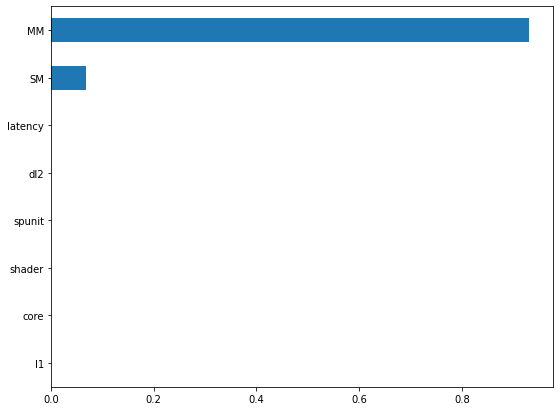

In [8]:
#feature importance
def random_forest_n_runs_feat_importance(x_data, y_data, forest_model, runs, features):
    feature_importance_array = []
    
    for i in range(features):
        feature_importance_array.append(np.zeros(runs))
    
    for run in range(0, runs):
        forest_model.fit(x_data, y_data)
        importances = forest_model.feature_importances_
        for k in range(features):
            feature_importance_array[k][run] = importances[k]
        #print(importances)
    #print(feature_importance_array)
    return feature_importance_array

#random forest optimization
print("Using the GridSearchCV to find the best parameter")

parameters = {'n_estimators':[100+10*n for n in range(1,10)],
            'criterion':['squared_error', 'absolute_error', 'poisson'], 
            'min_samples_split':[i for i in range(2, 10)]}

RF = RandomForestRegressor()
clf_RF = GridSearchCV(RF, parameters, cv=5)

results_RF = clf_RF.fit(X, Y)
print(results_RF.best_estimator_)

NUMBER_OF_RUNS = 20
FEATURES = 8

feat_importance = random_forest_n_runs_feat_importance(X, Y, results_RF.best_estimator_, NUMBER_OF_RUNS, FEATURES )
avg_feat_importance = np.zeros(FEATURES)
for f in range(len(feat_importance)):
    avg_feat_importance[f]= feat_importance[f].mean()

print(avg_feat_importance)
feat_importance = pd.Series(avg_feat_importance, index = df.columns[0:8]).sort_values()
#df_clean bounds of input data
print(feat_importance)
plt.figure(figsize=(9,7))
feat_importance.plot(kind='barh')
plt.show()

In [ ]:
data_arr = df1.to_numpy()
X, Y = x_y_split(data_arr, 0, 5, 6)
groups = group_dataset(data_arr, 1) #clinician

Using the GridSearchCV to find the best parameter
RandomForestRegressor(criterion='absolute_error', min_samples_split=3,
                      n_estimators=180)
[5.55579154e-02 6.94509298e-01 2.02900685e-01 8.41545204e-05
 3.97991952e-02 7.14875192e-03]
core       0.000084
latency    0.007149
l1         0.039799
SM         0.055558
shader     0.202901
MM         0.694509
dtype: float64


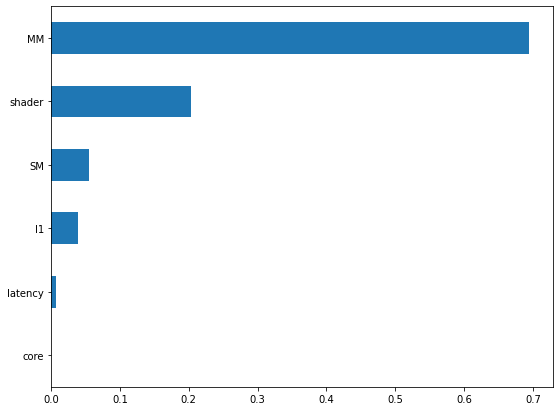

In [ ]:
#feature importance
def random_forest_n_runs_feat_importance(x_data, y_data, forest_model, runs, features):
    feature_importance_array = []
    
    for i in range(features):
        feature_importance_array.append(np.zeros(runs))
    
    for run in range(0, runs):
        forest_model.fit(x_data, y_data)
        importances = forest_model.feature_importances_
        for k in range(features):
            feature_importance_array[k][run] = importances[k]
        #print(importances)
    #print(feature_importance_array)
    return feature_importance_array

#random forest optimization
print("Using the GridSearchCV to find the best parameter")

parameters = {'n_estimators':[100+10*n for n in range(1,10)],
            'criterion':['squared_error', 'absolute_error', 'poisson'], 
            'min_samples_split':[i for i in range(2, 10)]}

RF = RandomForestRegressor()
clf_RF = GridSearchCV(RF, parameters, cv=5)

results_RF = clf_RF.fit(X, Y)
print(results_RF.best_estimator_)

NUMBER_OF_RUNS = 20
FEATURES = 6

feat_importance = random_forest_n_runs_feat_importance(X, Y, results_RF.best_estimator_, NUMBER_OF_RUNS, FEATURES )
avg_feat_importance = np.zeros(FEATURES)
for f in range(len(feat_importance)):
    avg_feat_importance[f]= feat_importance[f].mean()

print(avg_feat_importance)
feat_importance = pd.Series(avg_feat_importance, index = df.columns[0:6]).sort_values()
#df_clean bounds of input data
print(feat_importance)
plt.figure(figsize=(9,7))
feat_importance.plot(kind='barh')
plt.show()

In [ ]:
#Random Forest Regressor
print("Random Forest Regressor")
from sklearn.ensemble import RandomForestRegressor
params_RF = {'n_estimators':[a*100 for a in range(1,2)]
            ,'max_depth':[i for i in range(2, 5)]
            , 'criterion':['mse', 'mae']}
best_RF_regressor, RFR_scoring = \
    outer_cross_val(X, Y, groups, LeaveOneGroupOut(), RandomForestRegressor(), params_RF, \
                    'Regression', 2)
RFR_score, average_RFR, RFR_cm, Y_test, Y_pred = RFR_scoring
Y_pred_q = np.round_(Y_pred, decimals = 0)

best_RFR_cm = metrics.confusion_matrix(Y_test, Y_pred_q, labels_for_matrix)
best_RFR_kappa = metrics.cohen_kappa_score(Y_test, Y_pred_q)

print("best score - mean squared error: %.6f" % RFR_score)
print("average score: %.6f " % average_RFR)
print("Best Confusion Matrix ")
print(best_RFR_cm)
print(metrics.classification_report(Y_test, Y_pred_q))
print("Cohen Kappa: %.6f" % best_RFR_kappa)
print("Consolidated Confusion Matrix ")
print(RFR_cm)
print(accuracy_from_confusion_matrix(RFR_cm))
print("Overall accuracy:  %.8f "%(accuracy_from_confusion_matrix(RFR_cm)))

print(best_RF_regressor)
#use the model to predict
#Y_model = best_RF_regressor.predict(X)
#Y_model = np.round(Y_model, 0)
#print("Testing the model on the data set")
#print(metrics.confusion_matrix(Y, Y_model, labels_for_matrix))
#print(metrics.classification_report(Y, Y_model))